In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys
import struct
import time
import pandas as pd

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm

%matplotlib inline

In [2]:
subject = "1"

In [3]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+f"/nsddata_betas/ppdata/subj0{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/"
BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"


DEVICE = 'cpu'

Currently  our correlation-based metric _underestimates_ the amount of variance explained, because we correlate predicted and observed betas across all trials; including image repetitions. 

The voxel response, however, will be different for each repetition due to noise. We can minimize the noise if we take the average of the betas across repetitions for each image. 


Now we compute the metric across all unique images (because they are all mean betas). that is the kind of variance that our model tries to explain.

In [4]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')
resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,1,1,1,1,46002,625,0.505082,0,1.0,803.529781,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,1,1,1,2,61882,5012,0.505128,0,1.0,972.261383,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,1,1,1,3,828,4849,0.505175,0,1.0,742.351236,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,1,1,1,4,67573,8822,0.505221,0,1.0,747.518479,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,1,1,1,5,16020,9537,0.505267,0,1.0,547.422774,0.0,NaN,NaN,0,1.0,1,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,40,12,58,13773,8983,262.629551,1,0.0,1275.300175,0.0,20963.0,21540.0,0,1.0,1,0,1.0,0
29996,1,40,12,59,66767,6025,262.629597,1,1.0,661.379768,0.0,16.0,17622.0,1,1.0,0,1,2.0,0
29997,1,40,12,60,53167,4840,262.629644,1,1.0,786.811781,0.0,9483.0,11912.0,0,0.0,0,1,2.0,0
29998,1,40,12,61,1943,7322,262.629690,1,1.0,502.626801,0.0,83.0,12162.0,1,1.0,0,1,2.0,0


In [5]:
img_indices = resp_subj1['73KID']

In [6]:
# get for each imagae the unqiue indices when they were shown ,since each image was shown 3 times -> we will have 3 indices for each image index

grouped = resp_subj1.groupby('73KID')

result = [] 

for img_idx, group in grouped:
    indices  = group.index.tolist()
    
    sessions = group['SESSION'].tolist()
    runs = group['RUN'].tolist()
    trials = group['TRIAL'].tolist()
    
    for index, session, run, trial in zip(indices, sessions, runs, trials):
        
        result.append({
            'img_idx': img_idx, 
            'session': session,
            'run': run,
            'trial': trial,
            'original_idx': index, 
        })
    
avg_df_subj1 = pd.DataFrame(result)


In [7]:
avg_df_subj1

,img_idx,session,run,trial,original_idx
0,13,2,2,29,841
1,13,24,6,33,17595
2,13,24,10,24,17836
3,27,5,4,18,3205
4,27,23,7,49,16923
...,...,...,...,...,...
29995,72992,9,7,50,6424
29996,72992,10,2,35,6847
29997,72999,22,8,18,16205
29998,72999,30,11,14,22388


In [8]:
avg_df_subj1_dict = {}

# Iterate through rows of the DataFrame and populate the dictionary
for row in avg_df_subj1.itertuples():
    img_idx = row.img_idx
    original_index = row.original_idx
    
    # Check if img_idx is already a key in the dictionary
    if img_idx in avg_df_subj1_dict:
        avg_df_subj1_dict[img_idx].append(original_index)
    else:
        avg_df_subj1_dict[img_idx] = [original_index]

In [9]:
avg_df_subj1_dict[46002]

[0, 12802, 25836]

In [10]:
avg_df_subj1_dict[845]

# These are the indices which we need to average, in the concatenated betas matrix 

[27948, 28063, 28291]

# Averaging the betas across images 

In [11]:
import pickle 

with open(DATA_PATH+'/num_voxel_rois_dict.pkl', 'rb') as fp: 
    num_voxel_rois_dict = pickle.load(fp)
    print(num_voxel_rois_dict)

{'v1': 7887, 'v2': 8296, 'v3': 7022, 'v4': 3976, 'ofa': 2077, 'ffa1': 2854, 'ffa2': 1823, 'atl': 935, 'eba': 17406, 'fba1': 2294, 'fba2': 2539, 'opa': 9393, 'ppa': 5927, 'rsc': 3360, 'owfa': 2701, 'vwfa_1': 4671, 'vwfa_2': 3009, 'mfs_words': 973, 'mtl_words': 675, 'vo1': 1263, 'vo2': 1839, 'phc1': 1141, 'phc2': 1032, 'mst': 303, 'hmt': 1665, 'lo2': 1099, 'lo1': 1966, 'v3b': 1830, 'v3a': 3957, 'ips0': 3450, 'ips1': 2755, 'ips2': 2969, 'ips3': 2960, 'ips4': 361, 'ips5': 72, 'spl1': 941, 'fef': 410}


In [12]:
NUM_SESSIONS = 37

In [13]:
import os 
import fnmatch

In [14]:
def gen_avg_betas(roi):
    
    betas_full_file_name = f"betas_full_{roi}.npy"
    betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
    betas_file = betas_file[1:,:] # remove the first dummy row 
    
    num_voxels = num_voxel_rois_dict[roi]
                                     
    beta_avg = [] 
    
    # orig_idx = [] 
    
    imgs_done = {}
    
    for idx, img_idx in tqdm(enumerate(img_indices)):
        
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        
        list_of_indices = avg_df_subj1_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < betas_file.shape[0]]
        
        group_average = np.mean(betas_file[valid_indices], axis = 0) 

        
        beta_avg.append(group_average)
        # orig_idx.append(img_idx) 
        
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(beta_avg)
        
        

In [15]:
beta_avg_v1 = gen_avg_betas('v1')

23842it [00:00, 37942.50it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
30000it [00:00, 31312.29it/s]


In [16]:
beta_avg_v1

array([[-0.68048474,  0.27007251, -0.08545868, ...,  0.79991264,
        -0.65290633, -0.01317169],
       [-0.77941106, -0.46458636, -0.32235219, ..., -0.07945126,
        -0.39616856, -0.58416185],
       [ 0.52492907,  0.12169994, -0.38596312, ..., -0.0202311 ,
        -0.24755049, -0.19825248],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [17]:
beta_avg_v1.shape


(10000, 7887)

In [18]:
# check out of bounds images 
# images where ALL of the indices are out of bounds for the betas 

roi = 'v1'

betas_full_file_name = f"betas_full_{roi}.npy"
betas_file = np.load(DATA_PATH+f"/{betas_full_file_name}")
betas_file = betas_file[1:,:] 

oob_images = [] 

for img_idx, indices in avg_df_subj1_dict.items(): 
    all_out_of_bounds = all( i >= betas_file.shape[0] for i in indices) 
    
    if all_out_of_bounds: 
        # print(f"Image {img_idx} is OOB")
        oob_images.append(img_idx) 

In [19]:
len(oob_images)

159

In [20]:
def save_averaged_betas_all_roi(roi_list, path):
    for roi in roi_list: 
        print(f"Averaging for {roi}")
        avg_betas = gen_avg_betas(roi)
        file_name = f"betas_full_avg_{roi}.npy"
        
        np.save(path+file_name, avg_betas)
        print(f"Successfully saved {roi} betas to disk")
        

In [21]:
roi_list = ["v1","v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]

averaged_beta_files_path = f"{DATA_PATH}/averaged_beta_files/"

In [101]:
save_averaged_betas_all_roi(roi_list, averaged_beta_files_path) 

Averaging for v1


30000it [00:00, 47390.87it/s]


Successfully saved v1 betas to disk
Averaging for v2


30000it [00:00, 45380.75it/s]


Successfully saved v2 betas to disk
Averaging for v3


30000it [00:00, 47666.61it/s]


Successfully saved v3 betas to disk
Averaging for v4


30000it [00:00, 74157.16it/s]


Successfully saved v4 betas to disk
Averaging for ofa


30000it [00:00, 106269.21it/s]


Successfully saved ofa betas to disk
Averaging for ffa1


30000it [00:00, 99340.24it/s] 


Successfully saved ffa1 betas to disk
Averaging for ffa2


30000it [00:00, 121107.62it/s]


Successfully saved ffa2 betas to disk
Averaging for atl


30000it [00:00, 142394.43it/s]


Successfully saved atl betas to disk
Averaging for eba


30000it [00:01, 18620.82it/s]


Successfully saved eba betas to disk
Averaging for fba1


30000it [00:00, 104002.61it/s]


Successfully saved fba1 betas to disk
Averaging for fba2


30000it [00:00, 97074.19it/s] 


Successfully saved fba2 betas to disk
Averaging for opa


30000it [00:00, 30606.58it/s]


Successfully saved opa betas to disk
Averaging for ppa


30000it [00:00, 61457.31it/s]


Successfully saved ppa betas to disk
Averaging for rsc


30000it [00:00, 99126.05it/s] 


Successfully saved rsc betas to disk
Averaging for owfa


30000it [00:00, 95372.56it/s]


Successfully saved owfa betas to disk
Averaging for vwfa_1


30000it [00:00, 70666.14it/s]


Successfully saved vwfa_1 betas to disk
Averaging for vwfa_2


30000it [00:00, 91602.76it/s]


Successfully saved vwfa_2 betas to disk
Averaging for mfs_words


30000it [00:00, 142563.99it/s]


Successfully saved mfs_words betas to disk
Averaging for mtl_words


30000it [00:00, 144102.14it/s]


Successfully saved mtl_words betas to disk
Averaging for vo1


30000it [00:00, 128807.14it/s]


Successfully saved vo1 betas to disk
Averaging for vo2


30000it [00:00, 110418.85it/s]


Successfully saved vo2 betas to disk
Averaging for phc1


30000it [00:00, 125943.22it/s]


Successfully saved phc1 betas to disk
Averaging for phc2


30000it [00:00, 139109.33it/s]


Successfully saved phc2 betas to disk
Averaging for mst


30000it [00:00, 159170.58it/s]


Successfully saved mst betas to disk
Averaging for hmt


30000it [00:00, 109761.95it/s]


Successfully saved hmt betas to disk
Averaging for lo2


30000it [00:00, 123564.31it/s]


Successfully saved lo2 betas to disk
Averaging for lo1


30000it [00:00, 106481.71it/s]


Successfully saved lo1 betas to disk
Averaging for v3b


30000it [00:00, 111033.56it/s]


Successfully saved v3b betas to disk
Averaging for v3a


30000it [00:00, 77704.39it/s]


Successfully saved v3a betas to disk
Averaging for ips0


30000it [00:00, 88545.40it/s]


Successfully saved ips0 betas to disk
Averaging for ips1


30000it [00:00, 91520.61it/s]


Successfully saved ips1 betas to disk
Averaging for ips2


30000it [00:00, 87788.94it/s]


Successfully saved ips2 betas to disk
Averaging for ips3


30000it [00:00, 91868.74it/s]


Successfully saved ips3 betas to disk
Averaging for ips4


30000it [00:00, 159007.66it/s]


Successfully saved ips4 betas to disk
Averaging for ips5


30000it [00:00, 195916.17it/s]


Successfully saved ips5 betas to disk
Averaging for spl1


30000it [00:00, 132615.87it/s]


Successfully saved spl1 betas to disk
Averaging for fef


30000it [00:00, 153537.96it/s]


Successfully saved fef betas to disk


In [22]:
def gen_avg_sal_maps(S_mat_type):
    
    num_pixels = 425 
    num_images = 30000
    
    if S_mat_type == 'deepgaze':
        S_mat_file_name = "S_mat_full_batched.npy"
        
    elif S_mat_type == 'edges':
        S_mat_file_name = "S_mat_edges.npy"
        
    elif S_mat_type == 'luminance':
        S_mat_file_name = "S_mat_luminance.npy"
        
    elif S_mat_type == 'saturation':
        S_mat_file_name = "S_mat_saturation.npy"
        
    elif S_mat_type == 'ittikoch':
        S_mat_file_name = "salmaps_all.mat"
    
    else:
        raise Exception("Argument 'S_mat_type' must be either 'deepgaze', 'edges', 'luminance' , 'saturation' or 'ittikoch'. ")    
    
    if S_mat_type == 'ittikoch':
        ittikoch_maps_dataset = h5py.File(DATA_PATH + "/"+ S_mat_file_name, 'r')
        S_mat = np.copy(ittikoch_maps_dataset['salmaplist'])
        ittikoch_maps_dataset.close()
        S_mat = S_mat.reshape(num_pixels, num_pixels, num_images)
        S_mat = S_mat.transpose(1, 0, 2)
        S_mat = S_mat.reshape(-1, num_images).T
                
    else:
        S_mat = np.load(DATA_PATH+f"/{S_mat_file_name}")

    
    if S_mat_type == 'deepgaze':
        S_mat = S_mat[1:,:] # remove dummy row 
    
    S_mat = S_mat[:27750,:] # remove the last 3 session voxels for session 38,39 and 40 
    
    S_mat_avg = [] 
    
    
    imgs_done = {}
    
    for idx, img_idx in enumerate(tqdm(img_indices)):
        
        # if the image has already been averaged, skip it 
        if img_idx in imgs_done:
            continue
        
        list_of_indices = avg_df_subj1_dict[img_idx]
        
        # filter out of bound indices 
        valid_indices = [i for i in list_of_indices if i < S_mat.shape[0]]
        
        group_average = np.mean(S_mat[valid_indices], axis = 0) 
        
        S_mat_avg.append(group_average)
        
        imgs_done[img_idx] = img_idx # add to a dict that can then skip the averaging again 
    
    return np.array(S_mat_avg)
        

In [106]:
np.mean(np.array([]))

/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [102]:
S_mat_averaged = gen_avg_sal_maps('deepgaze')

 92%|█████████▏| 27578/30000 [00:22<00:00, 4362.37it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:22<00:00, 1336.34it/s]


In [107]:
S_mat_averaged

array([[[-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        [-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        [-17.56979187, -17.56979187, -17.56979187, ..., -21.75280521,
         -22.06371472, -22.06371472],
        ...,
        [-17.74727829, -17.74727829, -17.74727829, ..., -17.74911501,
         -17.88831232, -17.88831232],
        [-17.8627866 , -17.8627866 , -17.8627866 , ..., -17.75817821,
         -17.89992529, -17.89992529],
        [-17.8627866 , -17.8627866 , -17.8627866 , ..., -17.75817821,
         -17.89992529, -17.89992529]],

       [[-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        [-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        [-17.77345169, -17.77345169, -17.77345169, ..., -21.88932844,
         -22.20205622, -22.20205622],
        ...,


In [103]:
S_mat_averaged.shape

(10000, 425, 425)

In [152]:
np.save(averaged_beta_files_path+"S_mat_averaged", S_mat_averaged)

# Correlations with averaged betas

In [162]:
beta_avg_v1.shape

(10000, 7887)

In [166]:
nan_rows = np.isnan(beta_avg_v1).any(axis = 1) 
beta_wo_nan_v1 = beta_avg_v1[~nan_rows]

In [168]:
beta_wo_nan_v1.shape

(9841, 7887)

In [24]:
def gen_corr_w_beta(roi, print_log, S_mat):
    
    num_pixels = 425 
    
    print(f"Computing correlation for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj1_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
   
    if print_log: 
        print(f"K matrix: {K_mat.shape}")
    
    betas_mat = np.load(averaged_beta_files_path+f"/betas_full_avg_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy")
   
    if print_log: 
        print(f"Betas matrix before valid: {betas_mat.shape}")
        print(f"Valid indices shape: {roi_valid_indices.shape}")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 
    
    
    # betas_val = betas_val[1:,:] # remove the first dummy row 
    if print_log: 
        print(f"Betas matrix: {betas_val.shape}")
    
    if S_mat.ndim !=2: # This means that the S_mat has not been unrolled 
        S_mat = S_mat.reshape(-1, num_pixels * num_pixels)
        
    # Remove NaN rows if present from both Betas and S_mat
    nan_rows = np.isnan(betas_val).any(axis = 1) 
    betas_val = betas_val[~nan_rows]
    S_mat = S_mat[~nan_rows]
    
    if print_log: 
        print(f"Betas matrix after nan removal: {betas_val.shape}")
    
    
    Y_hat = S_mat @ K_mat.T
    if print_log:
        print(f"Y_hat matrix: {Y_hat.shape}\n\n")      
    
    # Correlate between betas_valid and Y_hat 
    corr_mat = np.corrcoef(betas_val,Y_hat,rowvar = False) # Example: (27750, 4165) x (27750, 4165) for V1 

    return corr_mat

In [170]:
corr_mat_v1 = gen_corr_w_beta(roi = 'v1', print_log = True, S_mat = S_mat_averaged)

Computing correlation for v1

K matrix: (4165, 180625)
Betas matrix before valid: (10000, 7887)
Valid indices shape: (4165,)
Betas matrix: (10000, 4165)
Betas matrix after nan removal: (9841, 4165)
Y_hat matrix: (9841, 4165)




In [181]:
def generate_corr_full(roi_list, S_mat, print_log = False):
    '''
    Generate the correlation coeff for the given list of ROIs and return it as a dataframe 
    '''
    corr_vals = {}
    
    for roi in roi_list:
        corr_mat_roi = gen_corr_w_beta(roi = roi, S_mat = S_mat, print_log = print_log) 
        rel_size = (corr_mat_roi.shape[0])// 2
        corr_mat_rel_roi = corr_mat_roi[rel_size:,:rel_size]
        corr_vals[roi] = corr_mat_rel_roi.diagonal() 
        
    
    # Create a main dataframe to which all smaller dataframes (for each ROI) will be appended 
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff'])
    
    for key,val in corr_vals.items(): # Key: ROI, value: array of correlations
        roi_as_list = [key] * val.shape[0] # duplicate the roi string so that it's in the format we want 
        corr_val_list = val
        temp_df = pd.DataFrame({'ROI': roi_as_list, 'corr_coeff':corr_val_list})   
        df_main = pd.concat((df_main, temp_df))
        
    return df_main

In [173]:
viz_roi_list = ["v1","v2","v3","v4"]
floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
floc_words_roi_list = ["eba","fba1", "fba2"]
floc_places_roi_list = ["opa", "ppa", "rsc"]
floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]
       


In [ ]:
corr_df_viz = generate_corr_full(roi_list = viz_roi_list,S_mat =  S_mat_averaged)

In [178]:
sns.set_style("whitegrid")


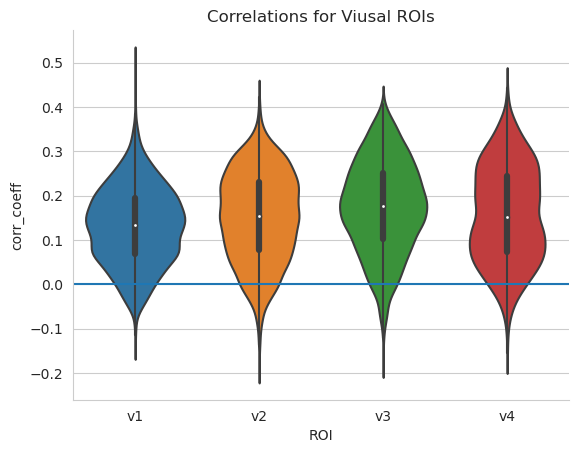

In [179]:
g = sns.violinplot(data = corr_df_viz_avg, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for Viusal ROIs');

## Plot previous type of graphs 

In [186]:
def concat_df_with_type(df_list , type_list):
    '''
    Concatenate the corr dataframes such that they each have a colunn 'type' which contains the type of the data. 
    Such as DeepGaze, edge, lumninance, etc.
    
    '''
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff', 'type'])
    
    for df, corr_type in zip(df_list, type_list):
        df_copy = df.copy()
        df_copy['type'] = corr_type
        df_main = df_main.append(df_copy)
    
    
    return df_main

In [182]:
corr_df_faces = generate_corr_full(roi_list = floc_faces_roi_list, S_mat = S_mat_averaged)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [210]:
corr_df_words = generate_corr_full(roi_list = floc_words_roi_list, S_mat = S_mat_averaged)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [ ]:
corr_df_places = generate_corr_full(roi_list = floc_places_roi_list, S_mat = S_mat_averaged)

Computing correlation for opa



In [ ]:
corr_df_bodies = generate_corr_full(roi_list = floc_bodies_roi_list, S_mat = S_mat_averaged)

In [ ]:
list_a = ["v3a","v3b", "ips0","ips1","ips2","ips3","ips4","ips5", "spl1","fef"]
list_b = ["vo1","vo2","lo1","lo2","phc1","phc2"]

In [ ]:
corr_df_list_a = generate_corr_full(roi_list = list_a, S_mat = S_mat_averaged)


In [ ]:
corr_df_list_b = generate_corr_full(roi_list = list_b, S_mat = S_mat_averaged)


### Edges 

In [189]:
S_mat_edges_averaged = gen_avg_sal_maps('edges')

 92%|█████████▏| 27622/30000 [00:50<00:00, 2431.67it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:50<00:00, 598.01it/s] 


In [286]:
np.save(averaged_beta_files_path+"S_mat_edges_averaged", S_mat_edges_averaged)

In [ ]:
corr_df_viz_edges = generate_corr_full(viz_roi_list, S_mat_edges_averaged)

In [ ]:
corr_df_faces_edges = generate_corr_full(floc_faces_roi_list, S_mat_edges_averaged, print_log = False)

In [ ]:
corr_df_words_edges = generate_corr_full(floc_words_roi_list, S_mat_edges_averaged, print_log = False)

In [ ]:
corr_df_places_edges = generate_corr_full(floc_places_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for rsc



In [ ]:
corr_df_bodies_edges = generate_corr_full(floc_bodies_roi_list, S_mat_edges_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [ ]:
corr_df_listA_edges = generate_corr_full(list_a, S_mat_edges_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [ ]:
corr_df_listB_edges = generate_corr_full(list_b, S_mat_edges_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



### Saturation and Luminance

In [209]:
S_mat_saturation_averaged = gen_avg_sal_maps('saturation')
S_mat_luminance_averaged = gen_avg_sal_maps('luminance')


 91%|█████████ | 27296/30000 [00:29<00:00, 3041.13it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 30000/30000 [00:29<00:00, 1027.20it/s]


In [287]:
np.save(averaged_beta_files_path+"S_mat_saturation_averaged", S_mat_saturation_averaged)

In [288]:
np.save(averaged_beta_files_path+"S_mat_luminance_averaged", S_mat_luminance_averaged)

In [ ]:
corr_df_viz_saturation = generate_corr_full(viz_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [ ]:
corr_df_viz_luminance = generate_corr_full(viz_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [ ]:
corr_df_faces_saturation = generate_corr_full(floc_faces_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [ ]:
corr_df_faces_luminance = generate_corr_full(floc_faces_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [ ]:
corr_df_bodies_saturation = generate_corr_full(floc_bodies_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [ ]:
corr_df_bodies_luminance = generate_corr_full(floc_bodies_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [ ]:
corr_df_places_saturation = generate_corr_full(floc_places_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [ ]:
corr_df_places_luminance = generate_corr_full(floc_places_roi_list, S_mat_luminance_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [ ]:
corr_df_words_saturation = generate_corr_full(floc_words_roi_list,S_mat_saturation_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [ ]:
corr_df_words_luminance = generate_corr_full(floc_words_roi_list, S_mat_luminance_averaged, print_log = False)

In [ ]:
corr_df_listA_saturation = generate_corr_full(list_a, S_mat_saturation_averaged, print_log = False)

In [ ]:
corr_df_listA_luminance = generate_corr_full(list_a, S_mat_luminance_averaged, print_log = False)

In [ ]:
corr_df_listB_saturation = generate_corr_full(list_b, S_mat_saturation_averaged, print_log = False)

In [ ]:
corr_df_listB_luminance = generate_corr_full(list_b, S_mat_luminance_averaged, print_log = False)

### Itti and Koch 

In [203]:
S_mat_ittikoch_averaged  = gen_avg_sal_maps('ittikoch')

100%|██████████| 30000/30000 [03:01<00:00, 165.38it/s] 


In [289]:
np.save(averaged_beta_files_path+"S_mat_ittikoch_averaged", S_mat_ittikoch_averaged)

In [ ]:
corr_df_viz_itti = generate_corr_full(viz_roi_list, S_mat_ittikoch_averaged, print_log = False)

In [240]:
def plot_corr_violinplot(df ,title = "Correlation" , palette = "Pastel1"):
    g = sns.violinplot(data = df, x = "ROI" , y = "corr_coeff", hue = "type", palette = palette)
    sns.despine()
    g.axhline(0)
    g.set(title = title);
    

/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

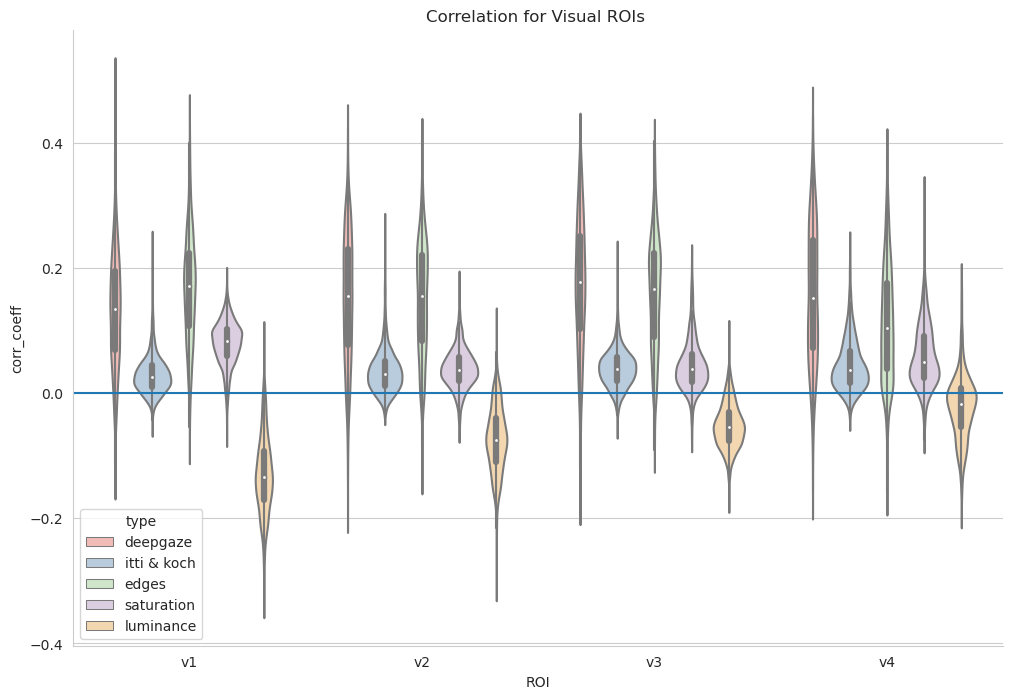

In [241]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_itti, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze", "itti & koch" , "edges", "saturation", "luminance"]),                   
                            title = "Correlation for Visual ROIs ")

In [242]:
corr_df_faces_itti = generate_corr_full(floc_faces_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

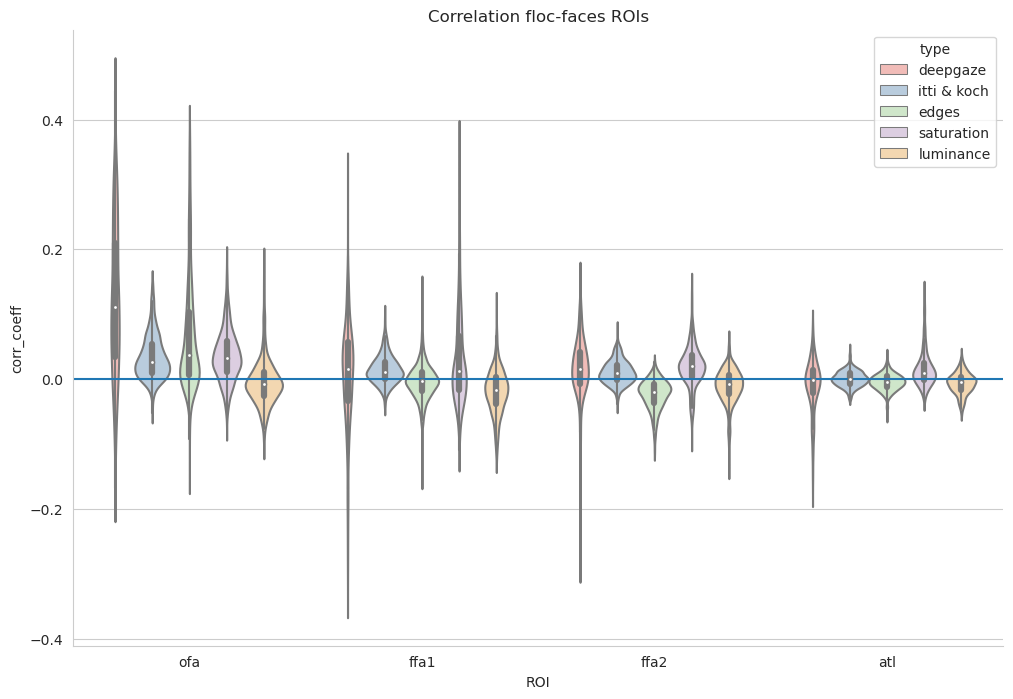

In [243]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                        df_list = [corr_df_faces, corr_df_faces_itti, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                      type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                          title = "Correlation floc-faces ROIs")

In [244]:
corr_df_bodies_itti = generate_corr_full(floc_bodies_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

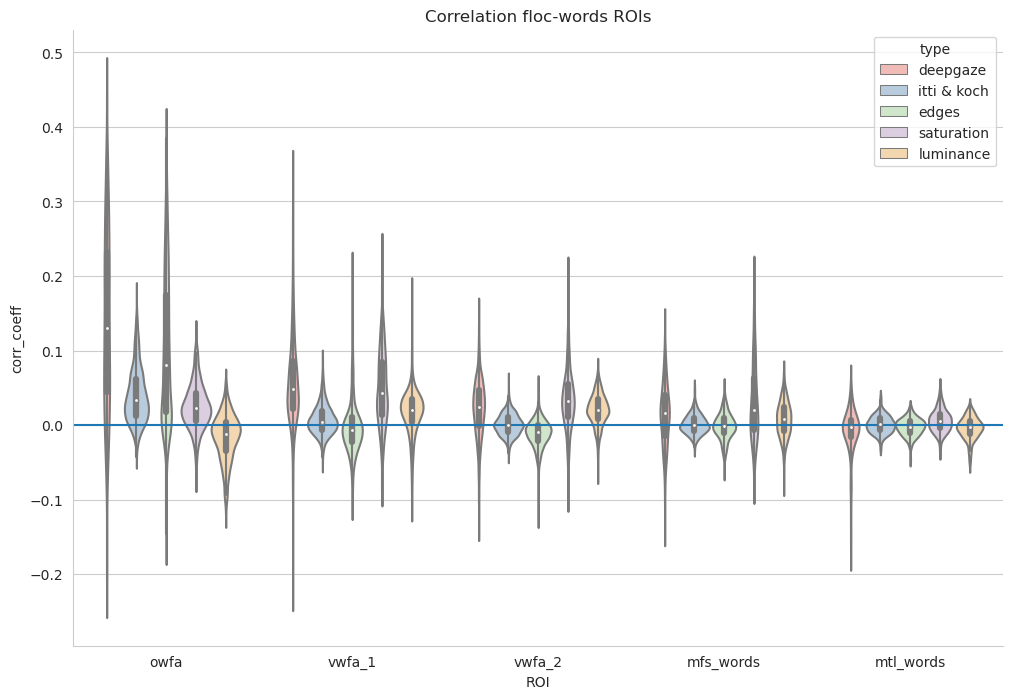

In [245]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_bodies, corr_df_bodies_itti, corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                      title = "Correlation floc-words ROIs")

In [246]:
corr_df_places_itti = generate_corr_full(floc_places_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

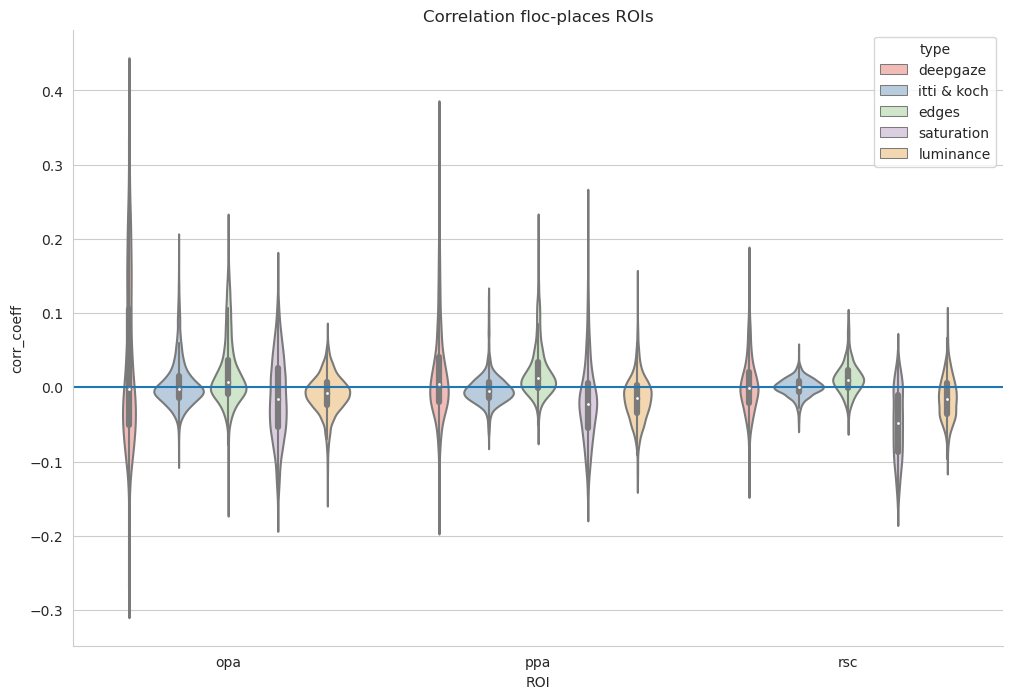

In [247]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_places, corr_df_places_itti, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-places ROIs")

In [248]:
corr_df_words_itti = generate_corr_full(floc_words_roi_list, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

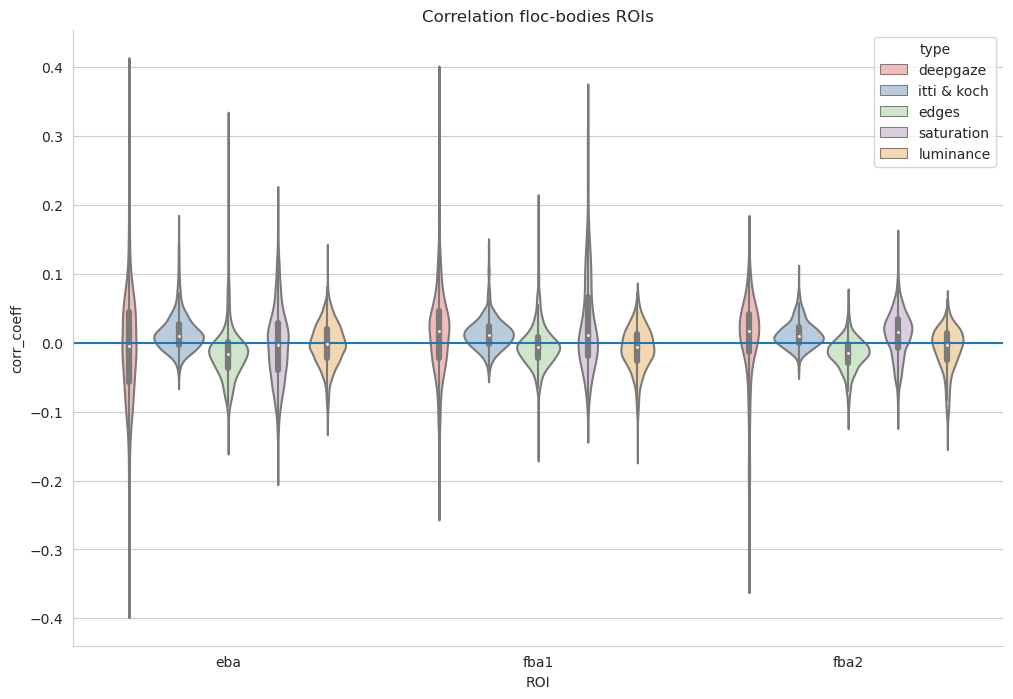

In [249]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_words, corr_df_words_itti, corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-bodies ROIs")

In [250]:
corr_df_listA_itti = generate_corr_full(list_a, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

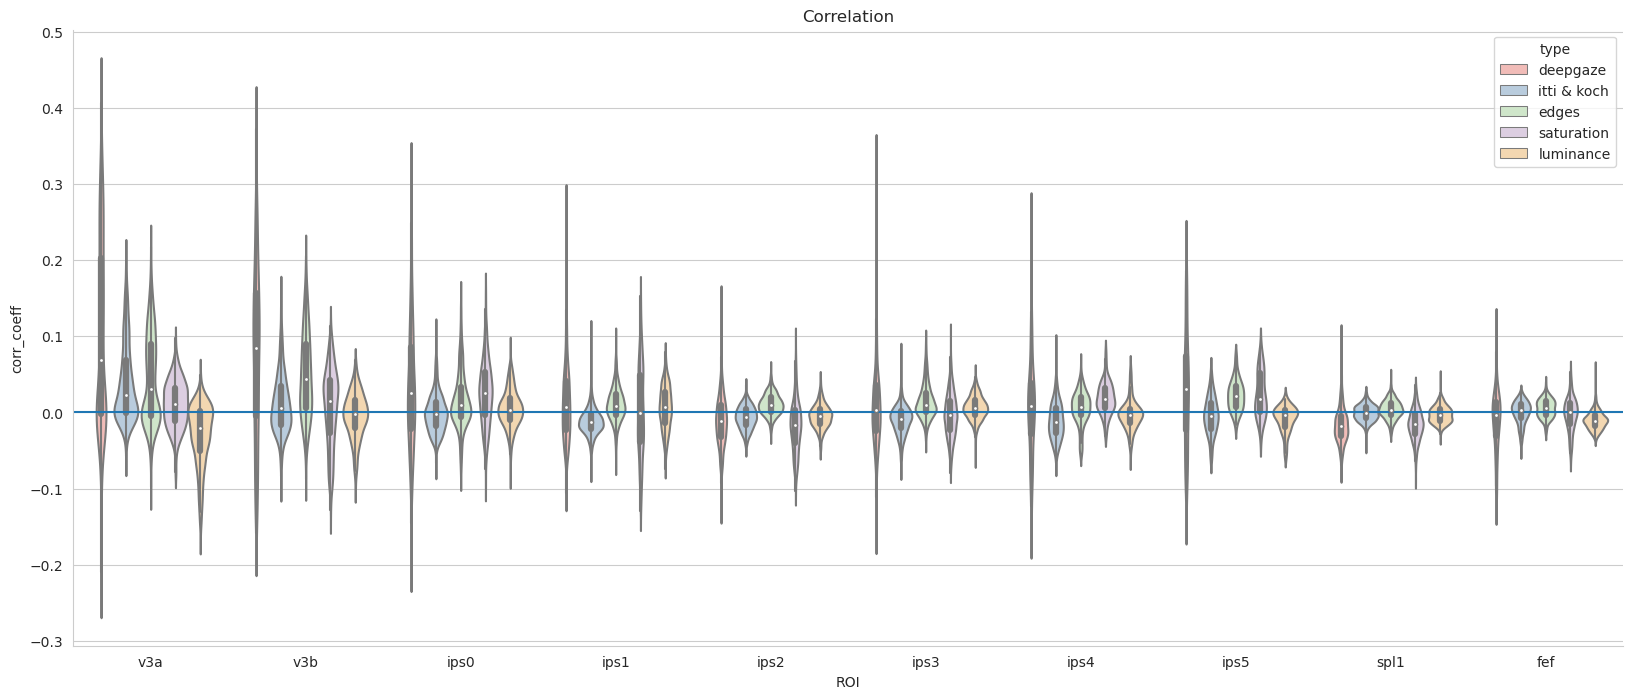

In [254]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_a, corr_df_listA_itti, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation")

In [252]:
corr_df_listB_itti = generate_corr_full(list_b, S_mat_ittikoch_averaged, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_70909/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

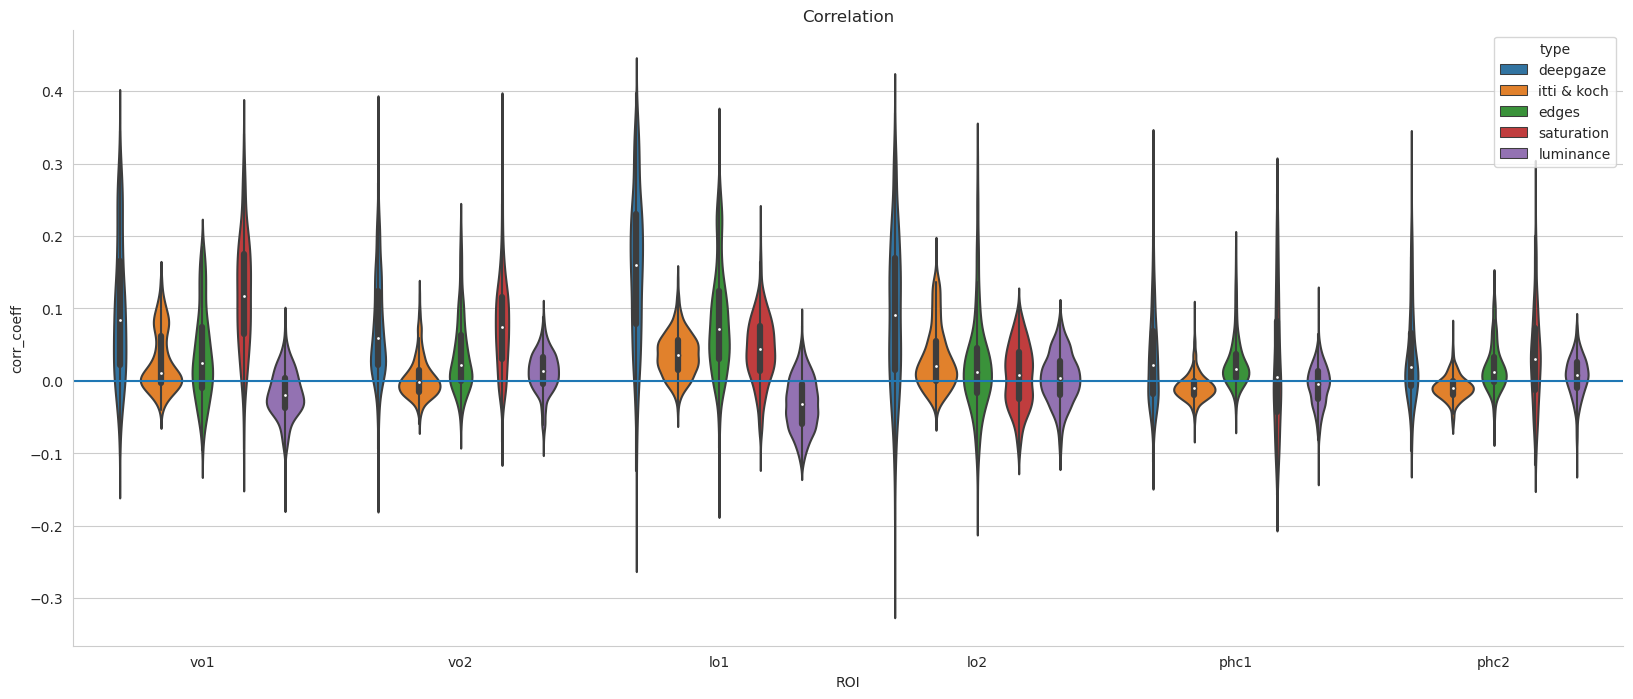

In [273]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_b, corr_df_listB_itti, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation",
                    palette = "tab10")

# Using spatial structure to get an accuracy metric for models 

We currently ignore the spatial structure of the predicted voxel response. Instead of correlating predicted and observed voxel time series, we can proceed image-by-image and apply an accuracy metric that compares the two vectors. 

In [124]:
def get_pred_and_observed_betas(roi, S_mat):
    
    num_pixels = 425 
    
    # print(f"Computing for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj1_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
    
    betas_mat = np.load(averaged_beta_files_path+f"/betas_full_avg_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 

    # TODO # Remove the voxels that were NaN for the  (DONE AFTER TAKING VALID INDICES)
    roi_non_zero_voxel_mask = np.load(DATA_PATH+f"/non_zero_voxel_mask_subj{subject}_{roi}.npy")
    
    # since the K had invalid rows removed from it , we need to remove the same rows from beta so that their shapes match 
    betas_val = betas_val[:, roi_non_zero_voxel_mask]

    
                                    
    
    # betas_val = betas_val[1:,:] # remove the first dummy row 
    if S_mat.ndim !=2: # This means that the S_mat has not been unrolled 
        S_mat = S_mat.reshape(-1, num_pixels * num_pixels)
        
    # Remove NaN rows if present from both Betas and S_mat
    nan_rows = np.isnan(betas_val).any(axis = 1) 
    betas_val = betas_val[~nan_rows]
    S_mat = S_mat[~nan_rows]
     
    
    Y_hat = S_mat @ K_mat.T
    
    
    # DEBUG
    nan_mask_yhat = np.isnan(Y_hat)
    nan_mask_smat = np.isnan(S_mat)
    nan_mask_kmat = np.isnan(K_mat)

    print(f"NaN values in Y_hat {Y_hat.shape} : {np.count_nonzero(nan_mask_yhat)}")
    print(f"NaN values in S_mat (after nan removal) {S_mat.shape} : {np.count_nonzero(nan_mask_smat)}")
    print(f"NaN values in K_mat {K_mat.shape} : {np.count_nonzero(nan_mask_kmat)}")

    
    

    return Y_hat, betas_val

In [116]:
# observed -> num_imgs x voxels 
# pred     -> num_imgs x voxels 

# 10000 distances for deepgaze
# 10000 dist for itti koch 
# standard error across the images 

In [ ]:
Y_hat_v1_dg , betas_v1 = get_pred_and_observed_betas('v1', S_mat_averaged) 

In [28]:
Y_hat_v1_dg.shape,  betas_v1.shape

((9841, 4165), (9841, 4165))

In [26]:
def get_similarity_cosine_2d(A,B):
    '''
    Calculate the cosine similarity of two 2D matrices A and B 
    '''
    cosine = np.sum(A*B, axis=1)/(norm(A, axis=1)*norm(B, axis=1))
    
    return cosine

In [37]:
def get_similarity_r2(A,B):
    '''
    Calculate the coefficient of determinant of two 2D matrices A and B 
    '''
    
    # A and B are of shape num_imgs x num_voxels 
    # we want to take the correlation across voxels within each image and then take mean across images for the specific ROI 
    
    
    # corr_matrix = np.corrcoef(A,B) # Since the rows (images) are the variables 
    
    corr_dict = {} 
    
    for row_idx in range(A.shape[0]): # Loop over the voxel response per image
        obs_for_img = A[row_idx]
        pred_for_img = B[row_idx]
        
        corr_for_img = np.corrcoef(obs_for_img, pred_for_img)
        
        corr_dict[row_idx] = corr_for_img[0,1]
     
    return corr_dict

In [61]:
def generate_similarity_all_rois(model, distance):
    num_pixels = 425 
    num_images = 30000
    
    if model == 'deepgaze':
        S_mat_file_name = "S_mat_averaged.npy"
        
    elif model == 'edges':
        S_mat_file_name = "S_mat_edges_averaged.npy"
        
    elif model == 'luminance':
        S_mat_file_name = "S_mat_luminance_averaged.npy"
        
    elif model == 'saturation':
        S_mat_file_name = "S_mat_saturation_averaged.npy"
        
    elif model == 'ittikoch':
        S_mat_file_name = "S_mat_ittikoch_averaged.npy" 
    else:
        raise Exception("Argument 'model' must be either 'deepgaze', 'edges', 'luminance' , 'saturation' or 'ittikoch'. ")
    
    
    
    S_mat = np.load(DATA_PATH+f"/averaged_beta_files/{S_mat_file_name}")
    
    rois = ["v1", "v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]
    
    similarities_rois = {} 
    
    
    for roi in tqdm(rois):
        pred, obs = get_pred_and_observed_betas(roi, S_mat) 
        
        if distance == 'cosine':
            similarity = get_similarity_cosine_2d(pred,obs)
        elif distance == 'r2':
            similarity = get_similarity_r2(pred,obs)
        
        similarities_rois[roi] = similarity
        
    
    return similarities_rois
   
    


In [51]:
# cosine_sim_deepgaze = generate_similarity_all_rois('deepgaze','cosine')

In [54]:
corr_sim_deepgaze = generate_similarity_all_rois('deepgaze','r2')

100%|██████████| 37/37 [44:52<00:00, 72.77s/it]  


In [55]:
corr_sim_edges = generate_similarity_all_rois('edges','r2')

100%|██████████| 37/37 [35:22<00:00, 57.37s/it]


In [56]:
corr_sim_luminance = generate_similarity_all_rois('luminance','r2')

100%|██████████| 37/37 [46:28<00:00, 75.37s/it]  


In [57]:
corr_sim_saturation = generate_similarity_all_rois('saturation','r2')

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 37/37 [45:21<00:00, 73.55s/it]  


In [62]:
corr_sim_ittikoch = generate_similarity_all_rois('ittikoch','r2')

100%|██████████| 37/37 [30:31<00:00, 49.51s/it]


In [112]:
def generate_mean_corrs_from_r2(corr_dict):
    mean_vals = {} 
    ul_vals = {} 
    ll_vals = {} 

    for roi, _ in tqdm(corr_dict.items()): 

        corrs = list(corr_dict[roi].values())
        corrs_z = np.arctanh(corrs)
        mn_corrs_z = np.mean(corrs_z)
        sem_corrs_z = np.std(corrs_z) / np.sqrt(len(corrs_z))
        ci_ul_corrs_z = mn_corrs_z + sem_corrs_z
        ci_ll_corrs_z = mn_corrs_z - sem_corrs_z
        mean_corr = np.tanh(mn_corrs_z)
        ci_ul_corrs = np.tanh(ci_ul_corrs_z)
        ci_ll_corrs = np.tanh(ci_ll_corrs_z)
        
        # mean_corr = np.tanh(np.mean(np.arctanh(corrs)))

        mean_vals[roi] = mean_corr
        ul_vals[roi] = ci_ul_corrs
        ll_vals[roi] = ci_ll_corrs
        
    
    return mean_vals, ul_vals, ll_vals

In [113]:
# corr_sim_deepgaze['ffa2']

In [122]:
Y_hat_ffa2_dg , betas_ffa2_dg = get_pred_and_observed_betas('ffa2', S_mat_averaged) 

NaN values in Y_hat (9841, 1316) : 0
NaN values in S_mat (after nan removal) (9841, 180625) : 0
NaN values in K_mat (1316, 180625) : 0


In [123]:
Y_hat_ffa2_dg.shape, betas_ffa2_dg.shape

((9841, 1316), (9841, 1344))

In [119]:
ffa2_dg_r2 = get_similarity_r2(Y_hat_ffa2_dg , betas_ffa2_dg)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1316 and the array at index 1 has size 1344

In [101]:
nan_mask = np.isnan(S_mat_ittikoch)

print(np.count_nonzero(nan_mask))

28719375


In [91]:
Y_hat_ffa2_dg.shape

(9841, 1344)

In [72]:
mean_corr_dg, ul_corr_dg, ll_corr_dg = generate_mean_corrs_from_r2(corr_sim_deepgaze)

100%|██████████| 37/37 [00:00<00:00, 840.26it/s]


In [75]:
mean_corr_dg

{'v1': 0.04499344704163918,
 'v2': 0.04696436197286182,
 'v3': 0.05655992883277959,
 'v4': 0.04788116411039504,
 'ofa': 0.025738341731121658,
 'ffa1': 0.01506016867066579,
 'ffa2': nan,
 'atl': 0.0007366251520313031,
 'eba': nan,
 'fba1': 0.012395757162480429,
 'fba2': nan,
 'opa': nan,
 'ppa': nan,
 'rsc': nan,
 'owfa': 0.013921654475409688,
 'vwfa_1': nan,
 'vwfa_2': nan,
 'mfs_words': -0.0010872427086870656,
 'mtl_words': -0.00031005140201175824,
 'vo1': 0.02044060664706799,
 'vo2': 0.010304607562651235,
 'phc1': -0.002925026414914774,
 'phc2': -0.0028192857849160514,
 'mst': 0.03499954038333571,
 'hmt': nan,
 'lo2': 0.020568925339779155,
 'lo1': 0.040952516552613165,
 'v3b': 0.02610977229546662,
 'v3a': nan,
 'ips0': 0.008242595207507851,
 'ips1': nan,
 'ips2': nan,
 'ips3': 0.0001961106092400459,
 'ips4': nan,
 'ips5': 0.009885230772778236,
 'spl1': 0.0006685797253688791,
 'fef': 0.0004949686585099153}

In [46]:
# # Average the correlations 
# mean_vals = {} 

# for roi, corr_dict in corr_sim_deepgaze.items(): 
    
#     corrs = list(corr_sim_deepgaze[roi].values())
#     mean_corr = np.tanh(np.mean(np.arctanh(corrs)))
    
#     mean_vals[roi] = mean_corr

In [63]:
mean_vals 

{'v1': 0.04499344704163918}

In [43]:
corr_sim_deepgaze

{'v1': {0: 0.0005258528260499782,
  1: 0.3921564292472716,
  2: -0.04266137573479277,
  3: -0.05683344248722443,
  4: -0.043113936430467896,
  5: -0.12187120831218108,
  6: 0.14263781606005144,
  7: 0.3506248306026092,
  8: 0.08508909287786043,
  9: -0.0625045380905649,
  10: -0.01995526303162717,
  11: 0.38011049748339715,
  12: -0.07764435880298602,
  13: 0.22579273666697092,
  14: 0.07784100723135425,
  15: -0.09157188361034053,
  16: 0.08649183506791944,
  17: 0.13443683060723072,
  18: 0.029814538398270782,
  19: -0.280959372489116,
  20: 0.09414180921728121,
  21: 0.06149751671512068,
  22: 0.06562099403992142,
  23: 0.3706613730975531,
  24: -0.030957681039818,
  25: 0.07576272916135043,
  26: 0.08416894340353938,
  27: 0.3673045530464919,
  28: 0.08296533856316136,
  29: -0.019938081862084435,
  30: 0.19194015252573549,
  31: 0.13474836376247692,
  32: 0.37460775009406716,
  33: 0.4320639068560211,
  34: -0.15922602025406685,
  35: 0.20962540631793508,
  36: -0.154909812126902,

In [280]:
# # now we find the cosine similarity 
# from numpy.linalg import norm


# similarity_cos_v1_dg = np.sum(Y_hat_v1_dg *  betas_v1, axis = 1) / (norm(Y_hat_v1_dg, axis = 1) * norm(betas_v1, axis = 1))

In [61]:
corr_v1 = np.corrcoef(Y_hat_v1_dg,betas_v1) # ((9841, 4165), (9841, 4165))

In [62]:
corr_v1.shape

(19682, 19682)

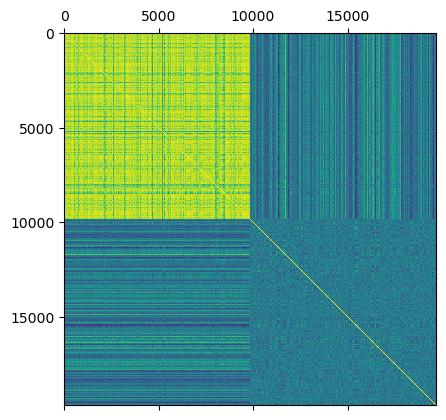

In [64]:
plt.matshow(corr_v1)

In [55]:
rng = np.random.default_rng(seed=42)
xarr = rng.random((3, 5))
yarr = rng.random((3, 5))

corr = np.corrcoef(xarr, yarr) 
corr2 = np.corrcoef(xarr)

In [59]:
xarr, yarr

(array([[0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735],
        [0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594],
        [0.37079802, 0.92676499, 0.64386512, 0.82276161, 0.4434142 ]]),
 array([[0.22723872, 0.55458479, 0.06381726, 0.82763117, 0.6316644 ],
        [0.75808774, 0.35452597, 0.97069802, 0.89312112, 0.7783835 ],
        [0.19463871, 0.466721  , 0.04380377, 0.15428949, 0.68304895]]))

In [71]:
corr_list = {} 

for row_idx in range(xarr.shape[0]): 
    pred_idx = xarr[row_idx]
    obs_idx = yarr[row_idx] 
    corr_idx = np.corrcoef(pred_idx,obs_idx)
    corr_list[row_idx] = corr_idx[0,1]
    
    

In [72]:
corr_list

{0: -0.5435119962948816, 1: -0.28835548679945155, 2: -0.10794277076737367}

In [56]:
corr.shape, corr2.shape

((6, 6), (3, 3))

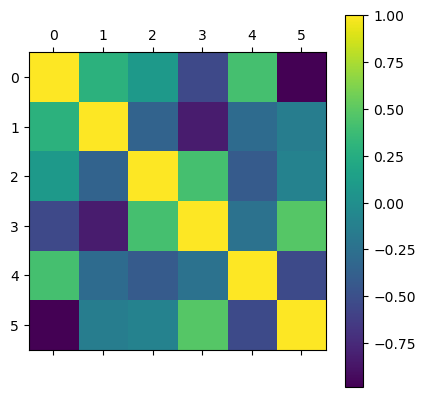

In [58]:
plt.matshow(corr)
plt.colorbar()

In [282]:
np.mean(similarity_cos_v1_dg)

-0.014727541882323779

In [285]:
from scipy import spatial

In [ ]:
spatial.distance.pdist(Y_hat_v1_dgbetas_v1,)

In [300]:
import numpy
actual = [1,2,3,4,5]
predict = [1,2.5,3,4.9,4.9]
 
corr_matrix = numpy.corrcoef(actual, predict)
corr = corr_matrix[0,1]
corr_mat2 = np.corrcoef(

In [301]:
corr_matrix.shape

(2, 2)

In [44]:
array1 = np.array([[1, 2, 3],
                   [4, 5, 6]])

array2 = np.array([[7, 8, 9],
                   [10, 11, 12]])

# Calculate the correlation coefficient
corr_matrix = np.corrcoef(array1, array2)

print(corr_matrix)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
